# **Get data**

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [2]:
!kaggle datasets download saurabhshahane/fake-news-classification

Dataset URL: https://www.kaggle.com/datasets/saurabhshahane/fake-news-classification
License(s): Attribution 4.0 International (CC BY 4.0)
 97% 89.0M/92.1M [00:01<00:00, 91.3MB/s]
100% 92.1M/92.1M [00:01<00:00, 72.4MB/s]


In [3]:
! unzip fake-news-classification

Archive:  fake-news-classification.zip
  inflating: WELFake_Dataset.csv     


# *Imports*

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud
import nltk, re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense,Input,GlobalMaxPooling1D,Dropout
from tensorflow.keras.models import Model
from keras import optimizers
from tensorflow.keras.optimizers import Adam


nltk.download('stopwords')
stop_words = nltk.corpus.stopwords.words('english')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

# Quick data preparation

In [5]:
df = pd.read_csv("WELFake_Dataset.csv")

In [6]:
df.head()

,Unnamed: 0,title,text,label
0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,1,NaN,Did they post their votes for Hillary already?,1
2,2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1


In [7]:
df.isnull().sum()

,0
Unnamed: 0,0
title,558
text,39
label,0


In [9]:
df["title_text"] = df["title"] + df["text"]

In [11]:
df = df.drop_duplicates(subset=['title_text']).reset_index(drop=True)

In [ ]:
df = df.fillna('')

In [ ]:
df.shape

(63122, 5)

# Plot 1. Class distribution

<ipython-input-51-6e3170db1bfa>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='label', palette={'0':'g', '1': 'r'})


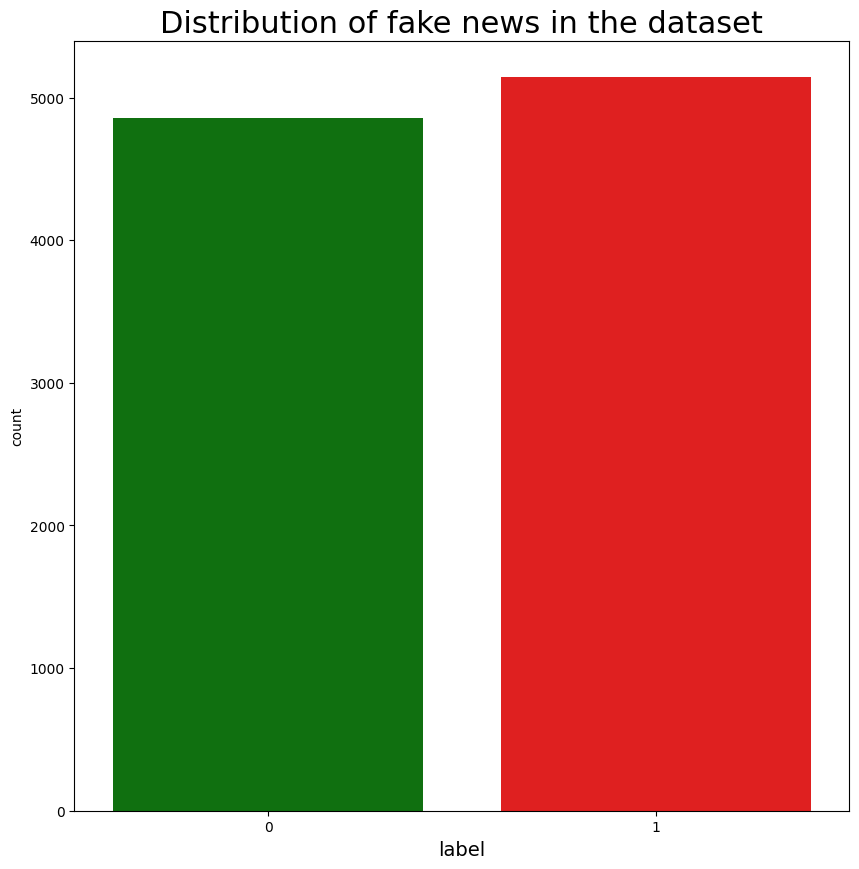

In [ ]:
plt.figure(figsize=(10, 10))
sns.countplot(data=df, x='label', palette={'0':'g', '1': 'r'})
plt.title('Distribution of fake news in the dataset', fontdict={'size':22})
plt.xlabel('label', fontsize=14)
plt.show()

# News preprocessing

## Clean texts

In [ ]:
def cleaner(text):
    text = text.lower()
    text = re.sub(r'\s+', ' ', text, flags=re.I)
    text = re.sub(r'\W', ' ', str(text))
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text) # Remove all single characters from text
    text = re.sub(r'[^a-zA-Z\s]', '', text) # Remove any character that isn't alphabetical

    return [word for word in word_tokenize(text) if word not in stop_words]

df['clean_texts'] = df['title_text'].apply(cleaner)

## Lemmatize texts

In [ ]:
lemmatizer = WordNetLemmatizer()
df['clean_texts'] = df['clean_texts'].apply(lambda text: [lemmatizer.lemmatize(word) for word in text])

In [ ]:
df['clean_texts'] = df['clean_texts'].apply(' '.join)

# Plot 2. Word cloud: only real news

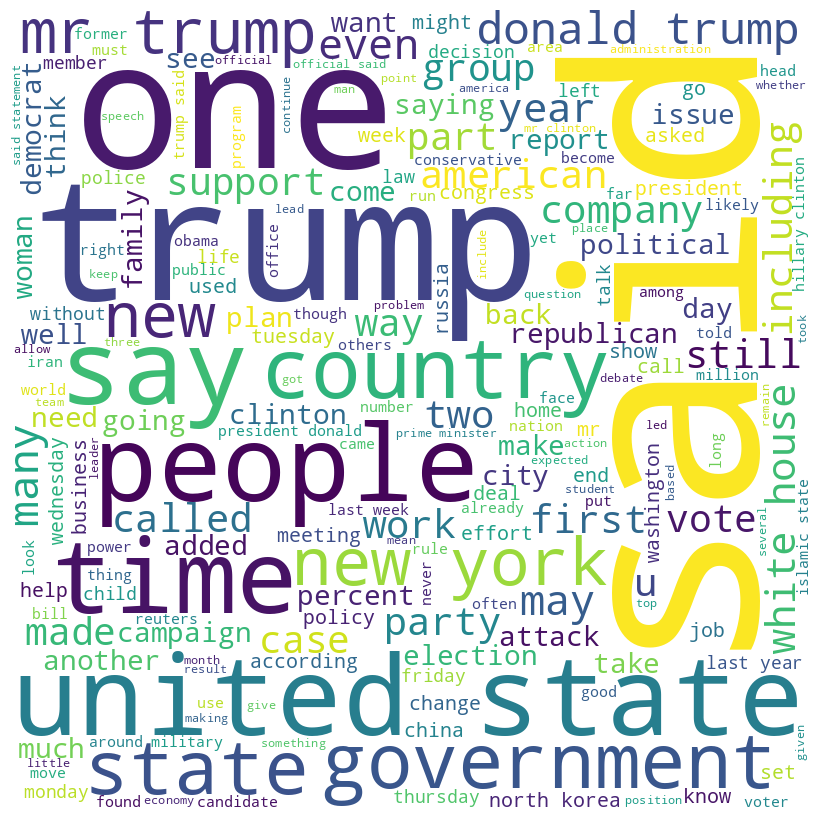

In [ ]:
comment_words = " ".join(df[df['label']==0]['clean_texts'])



wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                min_font_size = 10).generate(comment_words)

# plot the WordCloud image
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()

# Plot 3. World cloud: only fake news

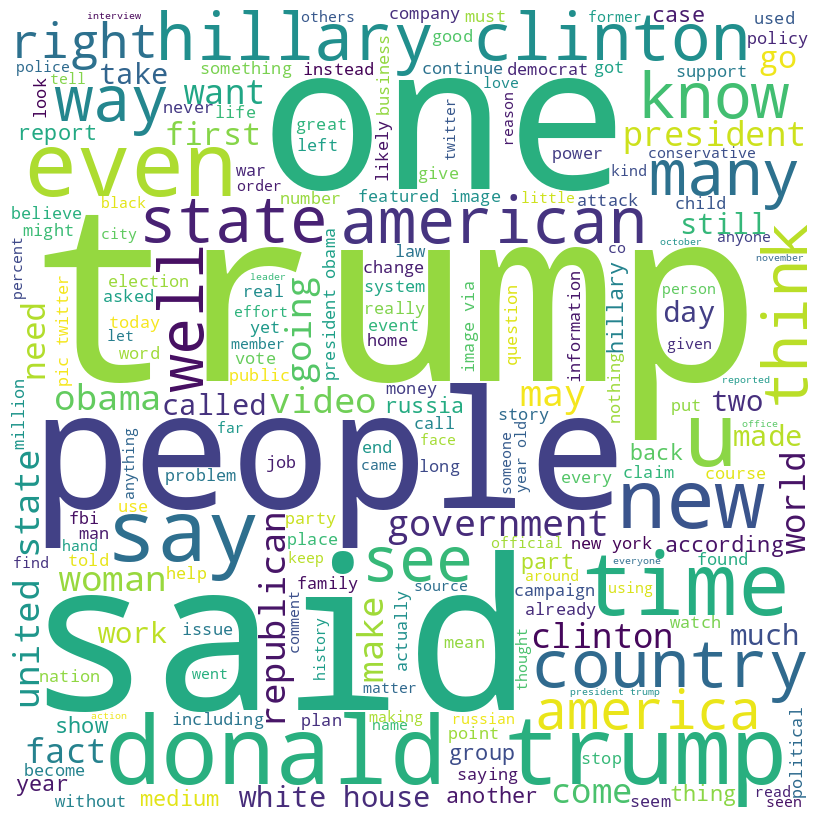

In [ ]:
comment_words = " ".join(df[df['label']==1]['clean_texts'])



wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                min_font_size = 10).generate(comment_words)

# plot the WordCloud image
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()

## As we can see, the most frequently used words for real and fictional news are not very different.

# Fake news detection

## Split data on train and test

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df['clean_texts'], df['label'], test_size=0.2, random_state=42)

# Make prediction with defolt models

## Tokenize & vectorize texts

In [ ]:
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

## Train & test models

In [ ]:
models = [
    MultinomialNB(),
    LogisticRegression(),
    RandomForestClassifier()
]

for model in models:
    model.fit(X_train_tfidf, y_train)
    y_pred = model.predict(X_test_tfidf)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"{model.__class__.__name__}: {accuracy*100:.2f}")

MultinomialNB: 85.55
LogisticRegression: 91.10
RandomForestClassifier: 90.20


# Make prediction with LSTM

## Tokenize & vectorize texts

In [ ]:
num_words = 20000
tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(X_train)

word_idx = tokenizer.word_index
vocab = len(word_idx)
print("the size of vocab =", vocab)

In [ ]:
train_text_seq = tokenizer.texts_to_sequences(X_train)
test_text_seq = tokenizer.texts_to_sequences(X_test)

In [ ]:
maxlen = 150
train_text_seq = pad_sequences(train_text_seq, maxlen=maxlen)
test_text_seq = pad_sequences(test_text_seq, maxlen=maxlen)

In [ ]:
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)
y_train_one_hot = tf.keras.utils.to_categorical(y_train_encoded)
y_test_one_hot = tf.keras.utils.to_categorical(y_test_encoded)

## Model building

In [ ]:
inp=Input(shape=(maxlen,))
learning_rate = 0.0001
x=Embedding(vocab+1,100)(inp)
x = Dropout(0.5)(x)
x = LSTM(150,return_sequences=True)(x)
x = Dropout(0.5)(x)
x = GlobalMaxPooling1D()(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(2, activation='softmax')(x)

model = Model(inp, x)

optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(train_text_seq, y_train_one_hot, epochs=10, validation_data=(test_text_seq, y_test_one_hot))

Epoch 1/2
250/250 ━━━━━━━━━━━━━━━━━━━━ 107s 427ms/step - accuracy: 0.5715 - loss: 0.6795 - val_accuracy: 0.7900 - val_loss: 0.4885
Epoch 2/2
250/250 ━━━━━━━━━━━━━━━━━━━━ 158s 496ms/step - accuracy: 0.8358 - loss: 0.4000 - val_accuracy: 0.8700 - val_loss: 0.3944


## Test model

In [ ]:
# Evaluate the model on the test data
loss, accuracy = model.evaluate(test_text_seq, y_test_one_hot)

print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 203ms/step - accuracy: 0.8765 - loss: 0.3951
Test Loss: 0.3944327235221863
Test Accuracy: 0.8700000047683716


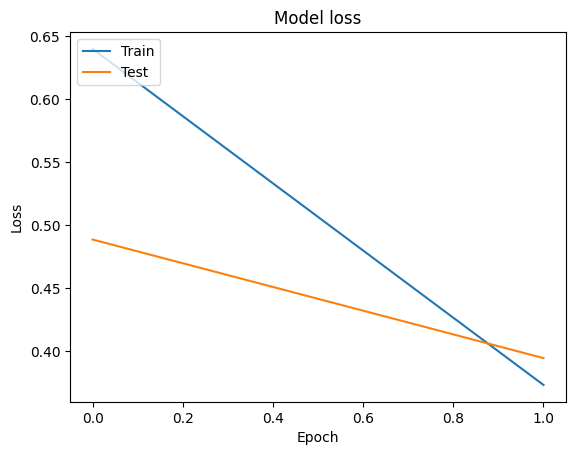

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

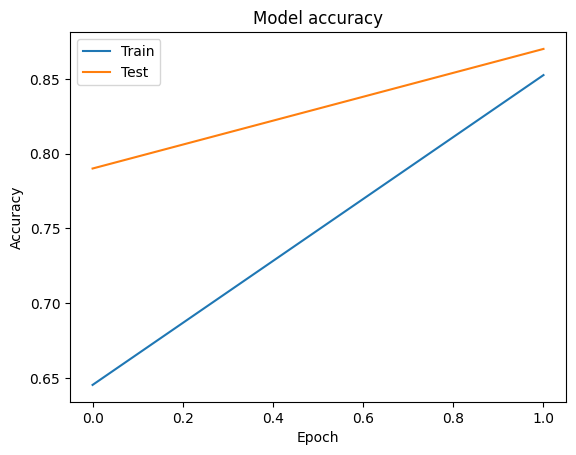

In [ ]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot 3-4. LSTM model accuracy and number of epochs

# The best accuracy of the conventional models was given by logistic regression - 0.91, while the lstm model trained on 10 epochs gave 0.94

# Thank you for your attention! ✊